In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty

In [74]:
from IPython.display import display, Markdown
from random import randint
from io import StringIO
from vectors import dot


def generate_random_matrix(rows: int, cols: int, min=-2, max=2):
    return tuple(
        tuple(randint(min, max) for _ in range(cols)) for _ in range(rows))


def latex_matrix(m: tuple[tuple[int]]) -> str:
    buffer = StringIO()
    print(r"\begin{pmatrix}", file=buffer)
    for row in m:
        if type(row) == int:
            # its a vector
            print(f"{row}" + r"\\", file=buffer)
        else:
            print(" & ".join([str(x) for x in row]) + r"\\", file=buffer)
    print(r"\end{pmatrix}", file=buffer)
    return buffer.getvalue()


def print_matrix(m: tuple[tuple[int]], label: str | None = None):
    lm = latex_matrix(m)
    if label:
        display(Markdown(f'**{label}**: $ {lm} $'))
    else:
        display(Markdown(f"$$ {lm} $$"))

def print_matrixes(*matrixes: list[tuple[tuple[int]]], label: str | None = None):
    lms = " ".join(['$ ' + latex_matrix(m) + ' $' for m in matrixes])
    if label:
        display(Markdown(f'**{label}**: {lms}'))
    else:
        display(Markdown(lms))

def matrix_multiply(a, b):
    return tuple(tuple(dot(row, col) for col in zip(*b)) for row in a)
from vectors import linear_combination


def multiply_matrix_vector(matrix, vector):
    return linear_combination(vector, *zip(*matrix))


In [91]:
# give it a subtract method
from typing import Self


class Vector(metaclass=ABCMeta):

    @abstractmethod
    def scale(self, scalar: int):
        pass

    @abstractmethod
    def add(self, other: Self):
        pass

    @abstractmethod
    def is_equal(self, other: Self):
        pass

    @abstractmethod
    def dot(self, other: Self):
        pass

    @property
    @abstractmethod
    def dimension(self):
        pass

    def __mul__(self, rhs):
        if isinstance(rhs, Vector):
            return self.dot(rhs)
        return self.scale(rhs)

    def __rmul__(self, lhs):
        if isinstance(lhs, Vector):
            return self.dot(lhs)
        return self.scale(lhs)

    def __add__(self, other):
        return self.add(other)

    def subtract(self, other):
        return self.add(-1 * other)

    def __sub__(self, other):
        return self.subtract(other)

    def __eq__(self, other):
        return self.is_equal(other)

**MINI-PROJECT:** Implement a `CoordinateVector` class inheriting from `Vector`, with an abstract property representing the dimension.  This should save repeated work implementing specific coordinate vector classes; all you should need to do to implement a Vec6 class should be inheriting from `CoordinateVector` and setting the dimension to 6.

In [92]:
from math import isclose
from typing import Self

class CoordinateVector(Vector):

    def __init__(self, coords: tuple[int]):
        self.coords = coords

    def scale(self, scalar: int):
        return CoordinateVector(tuple(x * scalar for x in self.coords))

    def _check_dimensions(self, rhs: Self):
        if self.dimension != rhs.dimension:
            raise ValueError("Refusing to operate on 2 vectors with different dimensions")


    def dot(self, rhs: Self):
        self._check_dimensions(rhs)
        return sum((a * b for (a,b) in zip(self.coords, rhs.coords)) )

    def add(self, other):
        self._check_dimensions(other)
        return CoordinateVector(tuple(a + b for a,b in zip(self.coords, other.coords)))

    def is_equal(self, other):
        self._check_dimensions(other)
        for (rhs, lhs) in zip(self.coords, other.coords):
            if not isclose(rhs, lhs):
                print("Not equal: %s != %s" % (rhs, lhs))
                return False
        return True
    
    @property
    def dimension(self):
        return len(self.coords)
    

    def __repr__(self):
        name = f"Vec{self.dimension}"
        return f"{name}{self.coords}"

    def display(self):
        print_matrix(self.coords)

    
        


In [21]:
from random import uniform
def random_scalar():
    return uniform(-10, 10)

def random_coordinate_vector(dim=2):
    return CoordinateVector(tuple(random_scalar() for _ in range(dim)))

def test_coords_vector(a: int, b: int, u: CoordinateVector, v: CoordinateVector, w: CoordinateVector):
    assert (u + v) == (v + u)
    assert u + (v + w) == (u + v) + w
    assert a * (b * v) == (a * b) * v
    assert 1 * v == v
    assert (a + b) * v == a * v + b * v
    assert a * v + a * w == a * (v + w)


In [25]:
v1 = CoordinateVector((1,2,3))
v2 = CoordinateVector((1,2,3, 4, 5))


Vec5(1, 2, 3, 4, 5)


In [35]:
for i in range(1):
    a, b = random_scalar(), random_scalar()
    u, v, w = random_coordinate_vector(6), random_coordinate_vector(
        6), random_coordinate_vector(6)
    test_coords_vector(a,b, u,v,w)


In [26]:
# plotting utility function for functions in this chapter
import numpy as np
import matplotlib.pyplot as plt
from math import sin

def plot(fs, xmin, xmax):
    xs = np.linspace(xmin,xmax,100)
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    for f in fs:
        ys = [f(x) for x in xs]
        plt.plot(xs,ys)

**EXERCISE:** Implement class `Function(Vector)` that takes a function of 1 variable as an argument to its constructor, with a `__call__` implemented so we can treat it as a function.  You should be able to run `plot([f,g,f+g,3*g],-10,10)`.

In [39]:
class Function(Vector):
    def __init__(self, *args):
        self.args = args
    def __call__(self, x: int):
        a, b = self.args
        return a * x + b
    def scale(self, scalar):
        return Function(*[scalar * a for a in self.args])

    def add(self, other):
        return Function(*[a + b for a, b in zip(self.args, other.args)])

    def is_equal(self, other):

        return self.args == other.args
    
    @property
    def dimension(self):
        return len(self.args)
    

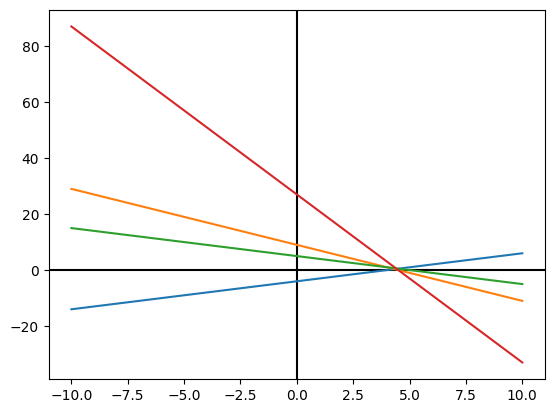

In [41]:
f = Function(1,-4)
g = Function(-2, 9)
plot([f,g, f+g, 3*g], -10, 10)

**MINI-PROJECT:** Implement a `Matrix` class inheriting from `Vector` with abstract properties representing number of rows and number of columns.  You should not be able to instantiate a Matrix class, but you could make a `Matrix5_by_3` by inheriting from Matrix and specifying the number of rows and columns explicitly.

In [110]:
from typing import Self


class Matrix(Vector):

    def __init__(self, matrix_rows: tuple[tuple[int] | CoordinateVector]):

        self.matrix = tuple(
            row if isinstance(row, CoordinateVector) else CoordinateVector(row)
            for row in matrix_rows)

    @property
    def rows(self):
        return len(self.matrix)

    @property
    def columns(self):
        return self.matrix[0].dimension

    @property
    def dimension(self):
        return self.rows

    def add(self, other):
        return Matrix(tuple(v + other.matrix[i] for (i, v) in self.matrix))

    def scale(self, scalar):
        return Matrix(tuple(v * scalar for v in self.matrix))

    def transpose(self):
        return Matrix(
            tuple(col) for col in zip(*(v.coords for v in self.matrix)))

    def dot(self, vec: CoordinateVector):
        return CoordinateVector(tuple(v * vec for v in self.matrix))

    def mul_on_matrix(self, rhs: Self):
        cols = tuple(self.dot(vec) for vec in rhs.transpose().matrix)
        print(cols)
        return Matrix(cols).transpose()

    def is_equal(self, other):
        return all((v == other[i] for (i, v) in enumerate(self.matrix)))

    def _as_matrix_rows(self):
        return tuple(row.coords for row in self.matrix)

    def __repr__(self):
        matrix_rows = self._as_matrix_rows()
        return str(matrix_rows)

    def display(self):
        matrix_rows = self._as_matrix_rows()
        print_matrix(matrix_rows)

    def __mul__(self, rhs: Self | CoordinateVector | int):
        if isinstance(rhs, Matrix):
            return self.mul_on_matrix(rhs)
        elif isinstance(rhs, CoordinateVector):
            return self.dot(rhs)
        else:
            return super().__mul__(rhs)

    def __rmul__(self, lhs: Self | CoordinateVector | int):
        if isinstance(lhs, Matrix):
            return self.mul_on_matrix(lhs)
        elif isinstance(lhs, CoordinateVector):
            return self.dot(lhs)
        else:
            return super().__mul__(lhs)


In [111]:
mrows = ((1, 1, 1), (2, 2, 2), (3,3,3))
vtuple = (1,2,3)
m = Matrix(mrows)
v = CoordinateVector(vtuple)
# m.display()
# m.transpose().display()


m * v
multiply_matrix_vector(mrows, vtuple)

matrix_multiply(mrows, mrows)

m * m




(Vec3(6, 12, 18), Vec3(6, 12, 18), Vec3(6, 12, 18))


((6, 6, 6), (12, 12, 12), (18, 18, 18))

In [93]:
a = CoordinateVector((1,2))
b = CoordinateVector((1,2))
a*b

5

In [ ]:
class MatrixAsMapFunction(Matrix):
    def __call__(self, vec):
        return self * vec